In [69]:
import sys
import os
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage import filters as skfilt

In [51]:
sys.path.append('/Users/mm40108/projects/datadays17/olfactory_protein_viz/src/')
from data.ABA_utils import get_products, get_genes, get_genes_from_aliases, get_experiments_and_images
from data.ABA_image_utils import get_image, get_organism_image_params, save_image_locally
from features.image_processing import read_images_in, process_raw_image, get_image_segment, monochrome_image, invert_image
from features.image_segmentation import try_thresholds, get_pixels, get_thresholds, apply_threshold
from visualization.make_plots import plot_expanding_rows, plot_channels
from ecallen.ecallen import images as ecimg

THIS_DIR = "/Users/mm40108/projects/datadays17/olfactory_protein_viz/src/data"
DATA_DIR = "/Users/mm40108/projects/datadays17/olfactory_protein_viz/data"
METADATA_DIR = "/Users/mm40108/projects/datadays17/olfactory_protein_viz/metadata"

In [36]:
# 0a. After running ingestion module, this is what we have so far
product = 'DevMouse'
genes = get_genes(product)
genes_of_interest = ['Robo2', 'Cdh5', 'Bmpr2']
our_genes = genes[genes.acronym.isin(genes_of_interest)]
our_gene_ids = our_genes.gene_id.values.tolist()
exp_data, img_data = get_experiments_and_images(genes_of_interest, organism=product)

	attempting query: http://api.brain-map.org/api/v2/data/Gene/query.json?criteria=model::Gene,rma::criteria,products[abbreviation$eq'DevMouse']&num_rows=all
	response: (2107, 16) 
	 Index(['acronym', 'alias_tags', 'chromosome_id', 'ensembl_id', 'entrez_id',
       'genomic_reference_update_id', 'homologene_id', 'gene_id',
       'legacy_ensembl_gene_id', 'name', 'organism_id', 'original_name',
       'original_symbol', 'reference_genome_id', 'sphinx_id',
       'version_status'],
      dtype='object')
	attempting query: http://api.brain-map.org/api/v2/data/Gene/query.json?criteria=model::Gene,rma::criteria,products[abbreviation$eq'DevMouse']&num_rows=all
	response: (2107, 16) 
	 Index(['acronym', 'alias_tags', 'chromosome_id', 'ensembl_id', 'entrez_id',
       'genomic_reference_update_id', 'homologene_id', 'gene_id',
       'legacy_ensembl_gene_id', 'name', 'organism_id', 'original_name',
       'original_symbol', 'reference_genome_id', 'sphinx_id',
       'version_status'],
      dtyp

	response: (18, 25) 
	 Index(['annotated', 'axes', 'bits_per_component', 'data_set_id',
       'expression_path', 'failed', 'height', 'id', 'image_height',
       'image_type', 'image_width', 'isi_experiment_id', 'lims1_id',
       'number_of_components', 'ophys_experiment_id', 'path',
       'projection_function', 'resolution', 'section_number', 'specimen_id',
       'structure_id', 'tier_count', 'width', 'x', 'y'],
      dtype='object')
getting all images for experiment_id 100047274
	attempting query: http://api.brain-map.org/api/v2/data/query.json?criteria=model::SectionImage,rma::criteria,[data_set_id$eq100047274]&num_rows=all
	response: (16, 25) 
	 Index(['annotated', 'axes', 'bits_per_component', 'data_set_id',
       'expression_path', 'failed', 'height', 'id', 'image_height',
       'image_type', 'image_width', 'isi_experiment_id', 'lims1_id',
       'number_of_components', 'ophys_experiment_id', 'path',
       'projection_function', 'resolution', 'section_number', 'specimen_id

	response: (16, 25) 
	 Index(['annotated', 'axes', 'bits_per_component', 'data_set_id',
       'expression_path', 'failed', 'height', 'id', 'image_height',
       'image_type', 'image_width', 'isi_experiment_id', 'lims1_id',
       'number_of_components', 'ophys_experiment_id', 'path',
       'projection_function', 'resolution', 'section_number', 'specimen_id',
       'structure_id', 'tier_count', 'width', 'x', 'y'],
      dtype='object')
getting all images for experiment_id 100056766
	attempting query: http://api.brain-map.org/api/v2/data/query.json?criteria=model::SectionImage,rma::criteria,[data_set_id$eq100056766]&num_rows=all
	response: (17, 25) 
	 Index(['annotated', 'axes', 'bits_per_component', 'data_set_id',
       'expression_path', 'failed', 'height', 'id', 'image_height',
       'image_type', 'image_width', 'isi_experiment_id', 'lims1_id',
       'number_of_components', 'ophys_experiment_id', 'path',
       'projection_function', 'resolution', 'section_number', 'specimen_id

read_images_in( /Users/mm40108/projects/datadays17/olfactory_protein_viz/data/DevMouse/Bmpr2/100042306/processed ): /Users/mm40108/projects/datadays17/olfactory_protein_viz/data/DevMouse/Bmpr2/100042306/processed/100878599_processed.jpg
	/Users/mm40108/projects/datadays17/olfactory_protein_viz/data/DevMouse/Bmpr2/100042306/processed/100878600_processed.jpg
	/Users/mm40108/projects/datadays17/olfactory_protein_viz/data/DevMouse/Bmpr2/100042306/processed/100878601_processed.jpg
	/Users/mm40108/projects/datadays17/olfactory_protein_viz/data/DevMouse/Bmpr2/100042306/processed/100878602_processed.jpg
	/Users/mm40108/projects/datadays17/olfactory_protein_viz/data/DevMouse/Bmpr2/100042306/processed/100878635_processed.jpg
	/Users/mm40108/projects/datadays17/olfactory_protein_viz/data/DevMouse/Bmpr2/100042306/processed/100878636_processed.jpg
	/Users/mm40108/projects/datadays17/olfactory_protein_viz/data/DevMouse/Bmpr2/100042306/processed/100878637_processed.jpg
	/Users/mm40108/projects/datada

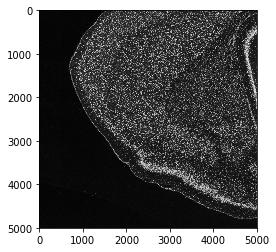

In [44]:
# 0b. After running basic processing, this is what we have
exp_ids = exp_data.experiment_id.values.tolist()
img_ids = img_data.id.values.tolist()

# 1a. choose one experiment and image to test processing on
gene = 'Bmpr2'
experiment = '100042306'
image = '100878599'

# preview slices in that experiment, under 'processed' directory
exp_params = ecimg.get_imaging_params(experiment)
exp_dir = os.path.join(DATA_DIR, product, gene, experiment, 'processed')
img_dict = read_images_in(exp_dir)

img_fname = os.path.join(exp_dir, image + '_processed.jpg')
img = img_dict[img_fname]
plt.imshow(img, cmap='gray')

{'yen': 80, 'otsu': 76, 'li': 53.43120012811344, 'iso': 76}


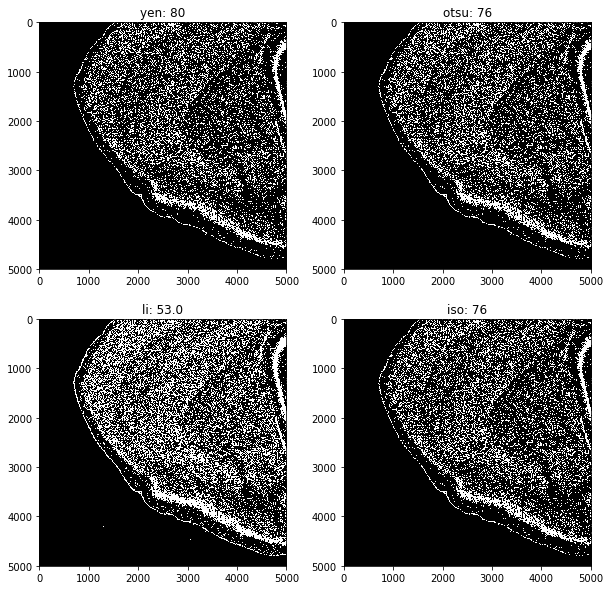

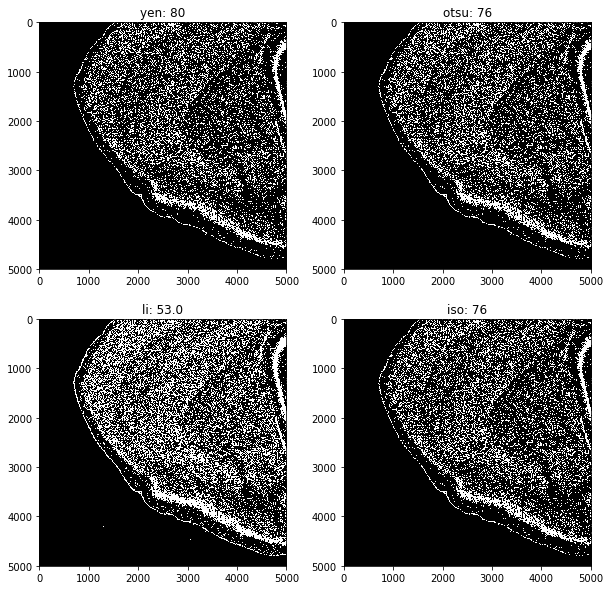

In [49]:
processed_dir = os.path.join(DATA_DIR, product, gene, experiment, 'processed')
rprops_dir = os.path.join(METADATA_DIR, product, gene, experiment, 'processed')

# 1. guide user through thresholding
try_thresholds(img, plt.figure(figsize=(10,10)))

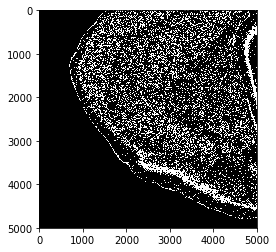

In [54]:
# binarize
# user picks a threshold, let's say  iso
bin_image = apply_threshold(img, 'iso')
plt.imshow(bin_image, cmap = 'gray')

In [55]:
# 2. guide user through extracting pixels + region properties
img_props = get_pixels(bin_image, min_neuron_pix = 20)

19541


In [58]:
iprops_df = pd.DataFrame(img_props)
iprops_df.head()

,area,bbox,neurons_x,neurons_y,orientation
0,462,"(0, 1531, 26, 1578)",1550.887446,14.205628,0.411424
1,28,"(0, 1647, 7, 1653)",1649.642857,3.071429,-1.083778
2,40,"(0, 1678, 4, 1690)",1683.050000,1.325000,0.046949
3,2857,"(0, 1736, 57, 1853)",1796.247462,21.789639,-0.022995
4,42,"(0, 1871, 4, 1887)",1878.476190,1.000000,0.025381


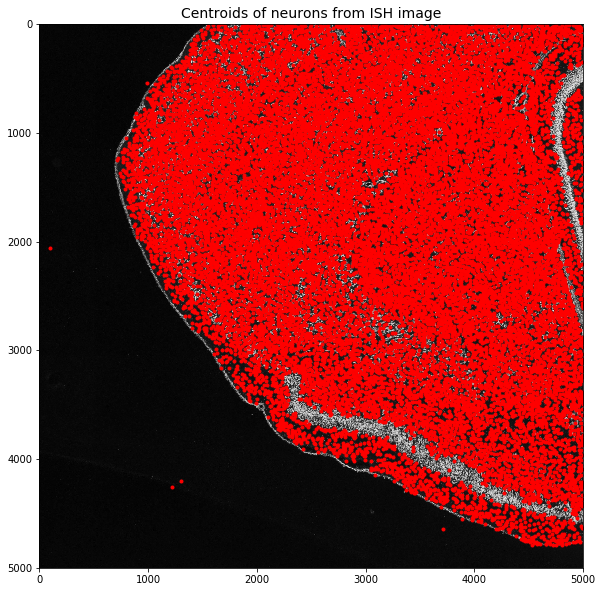

In [60]:
# 3. extract + plot pixels
x = iprops_df['neurons_x'].values.tolist()
y = iprops_df['neurons_y'].values.tolist()

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1,1,1)
ax.imshow(img,
          cmap='gray',
          interpolation='Nearest',
          origin='upper'
          )
ax.plot(x, y, 'r.')
ax.set_title('Centroids of neurons from ISH image', fontsize=14)
plt.show()

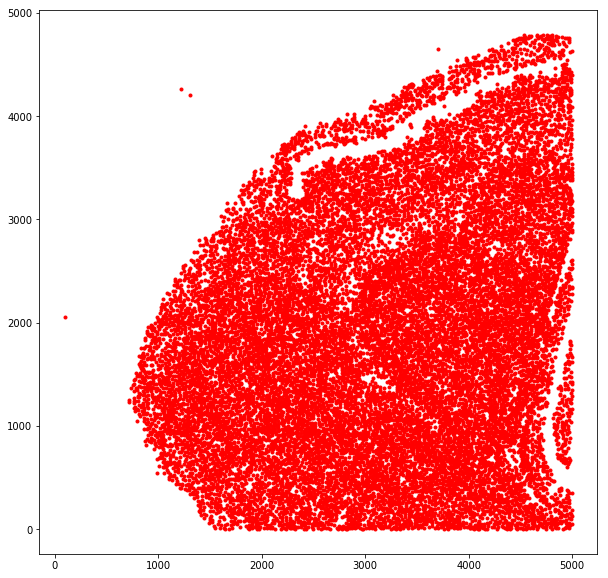

In [70]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
ax.plot(x, y, 'r.')